### References
https://github.com/vanvalenlab/deepcell-tf/blob/master/scripts/feature_pyramids/RetinaNet%20-%20Movie.ipynb

In [1]:
import os
import datetime
import errno
import argparse

import numpy as np

import tensorflow as tf
from tensorflow.python.keras import backend as K

import deepcell

# Load data

In [2]:
from deepcell.utils.data_utils import get_data
from deepcell.utils.tracking_utils import load_trks

DATA_DIR = '/data/training_data/cells/3T3/NIH/movie'
DATA_FILE = os.path.join(DATA_DIR, 'nuclear_movie_3T3_0-2_same.trks')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, mode='siamese_daughters', seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (192, 30, 154, 182, 1)
y.shape: (192, 30, 154, 182, 1)


# File Contants

In [3]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

# Loss

In [44]:
def assoc_features_loss(y_pred,
                        lmbda_diag=1e-3,
                        lmbda_off_diag=1e-3):
    
    def temp_norm(ten, axis=None):
        if axis is None:
            axis = 1 if K.image_data_format() == 'channels_first' else K.ndim(ten) - 1
        return K.sqrt(K.epsilon() + K.sum(K.square(ten), axis=axis))
    
    # Currently hard coded to use fpb = 3
        
    y_pred_shape = tf.shape(y_pred)
    Ncells = y_pred_shape[2]
    
    y_t1 = y_pred[:, 0:-1, :, :]
    y_t2 = y_pred[:, 1:, :, :]
    
    y_t1 = tf.expand_dims(y_t1, axis=2)
    y_t1 = tf.tile(y_t1, (1, 1, Ncells, 1, 1))
    
    y_t2 = tf.expand_dims(y_t2, axis=3)
    y_t2 = tf.tile(y_t1, (1, 1, 1, Ncells, 1))
    
    dot_prod = tf.tensordot(temp_norm(y_t1), temp_norm(y_t2), axes=3)
    dot_prod = tf.reshape(dot_prod, (-1, Ncells, Ncells))
    
    diagonal = tf.linalg.diag_part(dot_prod)
    off_diagonal = dot_prod - tf.linalg.diag(diagonal)
    
    loss_diagonal = - lmbda_diag * tf.reduce_mean(diagonal)
    loss_off_diagonal = lmbda_off_diag * tf.reduce_mean(off_diagonal)

    return loss_diagonal + loss_off_diagonal

# Model Parameters

In [45]:
# Each head of the model uses its own loss
from deepcell.losses import RetinaNetLosses
#from deepcell.losses import discriminative_instance_loss
from tensorflow.keras import losses

sigma = 3.0
alpha = 0.25
gamma = 2.0
iou_threshold = 0.5
max_detections = 100
mask_size = (28, 28)

retinanet_losses = RetinaNetLosses(
    sigma=sigma, alpha=alpha, gamma=gamma,
    iou_threshold=iou_threshold,
    mask_size=mask_size)

loss = {
    'regression': retinanet_losses.regress_loss,
    'classification': retinanet_losses.classification_loss,
    'association_features': assoc_features_loss, 
    'masks': retinanet_losses.mask_loss,
    'final_detection': retinanet_losses.final_detection_loss,
}

# Create RetinaMask Model

### Define Model

In [27]:
# Copyright 2016-2019 The Van Valen Lab at the California Institute of
# Technology (Caltech), with support from the Paul Allen Family Foundation,
# Google, & National Institutes of Health (NIH) under Grant U24CA224309-01.
# All rights reserved.
#
# Licensed under a modified Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.github.com/vanvalenlab/deepcell-tf/LICENSE
#
# The Work provided may be used for non-commercial academic purposes only.
# For any other use of the Work, including commercial use, please contact:
# vanvalenlab@gmail.com
#
# Neither the name of Caltech nor the names of its contributors may be used
# to endorse or promote products derived from this software without specific
# prior written permission.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""TrackRCNN models adapted from MaskRCNN and https://github.com/fizyr/keras-maskrcnn"""

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Add, Activation, Flatten, Dense
from tensorflow.python.keras.layers import Input, Concatenate
from tensorflow.python.keras.layers import TimeDistributed, Conv2D, Conv3D
from tensorflow.python.keras.layers import AveragePooling2D, AveragePooling3D
from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling3D
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.initializers import normal

from deepcell.layers import Cast, Shape, UpsampleLike
from deepcell.layers import Upsample, RoiAlign, ConcatenateBoxes
from deepcell.layers import ClipBoxes, RegressBoxes, FilterDetections
from deepcell.layers import TensorProduct, ImageNormalization2D, Location2D
from deepcell.layers import ImageNormalization3D, Location3D
from deepcell.model_zoo.retinanet import retinanet, __build_anchors
from deepcell.utils.retinanet_anchor_utils import AnchorParameters
from deepcell.utils.backbone_utils import get_backbone


def default_mask_model(num_classes,
                       pyramid_feature_size=256,
                       mask_feature_size=256,
                       roi_size=(14, 14),
                       mask_size=(28, 28),
                       name='mask_submodel',
                       mask_dtype=K.floatx(),
                       retinanet_dtype=K.floatx()):
    """Creates the default mask submodel.

    Args:
        num_classes (int): Number of classes to predict a score for at each
            feature level.
        pyramid_feature_size (int): The number of filters to expect from the
            feature pyramid levels.
        mask_feature_size (int): The number of filters to expect from the masks.
        roi_size (tuple): The number of filters to use in the Roi Layers.
        mask_size (tuple): The size of the masks.
        mask_dtype (str): Dtype to use for mask tensors.
        retinanet_dtype (str): Dtype retinanet models expect.
        name (str): The name of the submodel.

    Returns:
        tensorflow.keras.Model: a Model that predicts classes for
            each anchor.
    """
    options = {
        'kernel_size': 3,
        'strides': 1,
        'padding': 'same',
        'kernel_initializer': normal(mean=0.0, stddev=0.01, seed=None),
        'bias_initializer': 'zeros',
        'activation': 'relu',
    }

    inputs = Input(shape=(None, roi_size[0], roi_size[1], pyramid_feature_size))
    outputs = inputs

    # casting to the desidered data type, which may be different than
    # the one used for the underlying keras-retinanet model
    if mask_dtype != retinanet_dtype:
        outputs = TimeDistributed(
            Cast(dtype=mask_dtype),
            name='cast_masks')(outputs)

    for i in range(4):
        outputs = TimeDistributed(Conv2D(
            filters=mask_feature_size,
            **options
        ), name='roi_mask_{}'.format(i))(outputs)

    # perform upsampling + conv instead of deconv as in the paper
    # https://distill.pub/2016/deconv-checkerboard/
    outputs = TimeDistributed(
        Upsample(mask_size),
        name='roi_mask_upsample')(outputs)
    outputs = TimeDistributed(Conv2D(
        filters=mask_feature_size,
        **options
    ), name='roi_mask_features')(outputs)

    outputs = TimeDistributed(Conv2D(
        filters=num_classes,
        kernel_size=1,
        activation='sigmoid'
    ), name='roi_mask')(outputs)

    # casting back to the underlying keras-retinanet model data type
    if mask_dtype != retinanet_dtype:
        outputs = TimeDistributed(
            Cast(dtype=retinanet_dtype),
            name='recast_masks')(outputs)

    return Model(inputs=inputs, outputs=outputs, name=name)


def default_final_detection_model(pyramid_feature_size=256,
                                  final_detection_feature_size=256,
                                  roi_size=(14, 14),
                                  name='final_detection_submodel'):
    options = {
        'kernel_size': 3,
        'strides': 1,
        'padding': 'same',
        'kernel_initializer': normal(mean=0.0, stddev=0.01, seed=None),
        'bias_initializer': 'zeros',
        'activation': 'relu'
    }

    inputs = Input(shape=(None, roi_size[0], roi_size[1], pyramid_feature_size))
    outputs = inputs

    for i in range(2):
        outputs = TimeDistributed(Conv2D(
            filters=final_detection_feature_size,
            **options
        ), name='final_detection_submodel_conv1_block{}'.format(i))(outputs)
        outputs = TimeDistributed(Conv2D(
            filters=final_detection_feature_size,
            **options
        ), name='final_detection_submodel_conv2_block{}'.format(i))(outputs)
        outputs = TimeDistributed(MaxPool2D(
        ), name='final_detection_submodel_pool1_block{}'.format(i))(outputs)

    outputs = TimeDistributed(Conv2D(filters=final_detection_feature_size,
                                     kernel_size=3,
                                     padding='valid',
                                     kernel_initializer=normal(mean=0.0, stddev=0.01, seed=None),
                                     bias_initializer='zeros',
                                     activation='relu'))(outputs)

    outputs = TimeDistributed(Conv2D(filters=1,
                                     kernel_size=1,
                                     activation='sigmoid'))(outputs)

    outputs = Lambda(lambda x: tf.squeeze(x, axis=[2, 3]))(outputs)

    return Model(inputs=inputs, outputs=outputs, name=name)


def default_roi_submodels(num_classes,
#                           num_association_features,
                          roi_size=(14, 14),
                          mask_size=(28, 28),
                          frames_per_batch=1,
                          mask_dtype=K.floatx(),
                          retinanet_dtype=K.floatx()):
    """Create a list of default roi submodels.

    The default submodels contains a single mask model.

    Args:
        num_classes (int): Number of classes to use.
        roi_size (tuple): The number of filters to use in the Roi Layers.
        mask_size (tuple): The size of the masks.
        mask_dtype (str): Dtype to use for mask tensors.
        retinanet_dtype (str): Dtype retinanet models expect.

    Returns:
        list: A list of tuple, where the first element is the name of the
            submodel and the second element is the submodel itself.
    """
    if frames_per_batch > 1:
        return [
            ('masks', TimeDistributed(
                default_mask_model(num_classes,
                                   name='mask_submodel_0',
                                   roi_size=roi_size,
                                   mask_size=mask_size,
                                   mask_dtype=mask_dtype,
                                   retinanet_dtype=retinanet_dtype), name='mask_submodel')),
            ('final_detection', TimeDistributed(default_final_detection_model(roi_size=roi_size), 
                                                name = 'final_detection_submodel')),
#             ('association_features', TimeDistributed(
#                                      association_vector_model(num_association_features,
#                                          roi_size=roi_size,
#                                          name='assoc_vec_submodel_0',
#                                          frames_per_batch=frames_per_batch),
#                                      name='assoc_head_submodel'))
        ]
    return [
        ('masks', default_mask_model(num_classes,
                                     roi_size=roi_size,
                                     mask_size=mask_size,
                                     mask_dtype=mask_dtype,
                                     retinanet_dtype=retinanet_dtype))
        # ('final_detection', default_final_detection_model(roi_size=roi_size))
        ]

def default_assoc_head_submodel(num_classes,
                          num_association_features,
                          roi_size=(14, 14),
                          mask_size=(28, 28),
                          frames_per_batch=1,
                          mask_dtype=K.floatx(),
                          retinanet_dtype=K.floatx()):
    return [('association_features', TimeDistributed(
                                     association_vector_model(num_association_features,
                                         roi_size=roi_size,
                                         name='assoc_vec_submodel_0',
                                         frames_per_batch=frames_per_batch),
                                     name='assoc_head_submodel'))]

def association_vector_model(num_association_features,
                             roi_size=(14, 14),
                             pyramid_feature_size=256,
                             frames_per_batch=1,
                             name='assoc_head_submodel'):
    options = {
        'kernel_size': 3,
        'strides': 1,
        'padding': 'same',
        'kernel_initializer': normal(mean=0.0, stddev=0.01, seed=None),
        'bias_initializer': 'zeros',
        'activation': 'relu'
    }

    inputs = Input(shape=(None, roi_size[0], roi_size[1], 4))

    conv1 = TimeDistributed(Conv2D(
        filters=pyramid_feature_size,
        **options
    ), name='association_vector_submodel_conv1')(inputs)
    conv2 = TimeDistributed(Conv2D(
        filters=pyramid_feature_size,
        **options
    ), name='association_vector_submodel_conv2')(conv1)
    x = conv2
    x = TimeDistributed(MaxPool2D(
    ), name='association_vector_submodel_pool1')(conv2)

    # Residuals
    for i in range(2):
        x = TimeDistributed(Conv2D(filters=pyramid_feature_size,
                                   kernel_size=3,
                                   padding='valid',
                                   kernel_initializer=normal(mean=0.0, stddev=0.01, seed=None),
                                   bias_initializer='zeros',
                                   activation='relu', 
                                   name='association_vector_residual_conv1_block{}'.format(i)))(x)
        y = TimeDistributed(Conv2D(filters=pyramid_feature_size,
                                   kernel_size=3,
                                   padding='same',
                                   kernel_initializer=normal(mean=0.0, stddev=0.01, seed=None),
                                   bias_initializer='zeros',
                                   activation='relu',
                                   name='association_vector_residual_conv2_block{}'.format(i)))(x)
  
        x = Add(name='association_vector_residual_add_block{}'.format(i))([x, y])
        x = Activation('relu', name='association_vector_residual_relu_block{}'.format(i))(x)     


    y = TimeDistributed(AveragePooling2D(pool_size=3,
                        name='association_vector_averagepooling'))(x)
    
    outputs = TimeDistributed(Dense(num_association_features,
                    activation='softmax',
                    name='association_vector_dense_output'))(y)
    outputs = Lambda(lambda x: tf.squeeze(x, axis=[2, 3]))(outputs)

    print("outputs.shape", outputs.shape)
        
    return Model(inputs=inputs, outputs=outputs, name=name)


def retinanet_mask(inputs,
                   backbone_dict,
                   num_classes,
                   num_association_features,
                   frames_per_batch=1,
                   backbone_levels=['C3', 'C4', 'C5'],
                   pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
                   retinanet_model=None,
                   anchor_params=None,
                   nms=True,
                   panoptic=False,
                   use_assoc_head=False,
                   class_specific_filter=True,
                   crop_size=(14, 14),
                   mask_size=(28, 28),
                   name='retinanet-mask',
                   roi_submodels=None,
                   max_detections=100,
                   score_threshold=0.05,
                   nms_threshold=0.5,
                   mask_dtype=K.floatx(),
                   **kwargs):
    """Construct a RetinaNet mask model on top of a retinanet bbox model.
    Uses the retinanet bbox model and appends layers to compute masks.

    Args:
        inputs (tensor): List of tensorflow.keras.layers.Input.
            The first input is the image, the second input the blob of masks.
        num_classes (int): Integer, number of classes to classify.
        retinanet_model (tensorflow.keras.Model): RetinaNet model that predicts
            regression and classification values.
        anchor_params (AnchorParameters): Struct containing anchor parameters.
        nms (bool): Whether to use NMS.
        class_specific_filter (bool): Use class specific filtering.
        roi_submodels (list): Submodels for processing ROIs.
        name (str): Name of the model.
        mask_dtype (str): Dtype to use for mask tensors.
        kwargs (dict): Additional kwargs to pass to the retinanet bbox model.

    Returns:
        tensorflow.keras.Model: Model with inputs as input and as output
            the output of each submodel for each pyramid level and the
            detections. The order is as defined in submodels.

            ```
            [
                regression, classification, other[0], ...,
                boxes_masks, boxes, scores, labels, masks, other[0], ...
            ]
            ```

    """
    if anchor_params is None:
        anchor_params = AnchorParameters.default

    if roi_submodels is None:
        retinanet_dtype = K.floatx()
        K.set_floatx(mask_dtype)
        roi_submodels = default_roi_submodels(
            num_classes, crop_size, mask_size,
            frames_per_batch, mask_dtype, retinanet_dtype)
        assoc_head_submodel = default_assoc_head_submodel(
            num_classes, num_association_features, crop_size, mask_size,
            frames_per_batch, mask_dtype, retinanet_dtype)
        K.set_floatx(retinanet_dtype)
        
    image = inputs
    image_shape = Shape()(image)

    if retinanet_model is None:
        retinanet_model = retinanet(
            inputs=image,
            backbone_dict=backbone_dict,
            num_classes=num_classes,
            backbone_levels=backbone_levels,
            pyramid_levels=pyramid_levels,
            panoptic=panoptic,
            num_anchors=anchor_params.num_anchors(),
            frames_per_batch=frames_per_batch,
            **kwargs
        )

    # parse outputs
    regression = retinanet_model.outputs[0]
    classification = retinanet_model.outputs[1]

    if panoptic:
        # Determine the number of semantic heads
        n_semantic_heads = len([1 for layer in retinanet_model.layers if 'semantic' in layer.name])

        # The  panoptic output should not be sent to filter detections
        other = retinanet_model.outputs[2:-n_semantic_heads]
        semantic = retinanet_model.outputs[-n_semantic_heads:]
    else:
        other = retinanet_model.outputs[2:]


    features = [retinanet_model.get_layer(name).output
                for name in pyramid_levels]

    # build boxes
    anchors = __build_anchors(anchor_params, features,
                              frames_per_batch=frames_per_batch)
    boxes = RegressBoxes(name='boxes')([anchors, regression])
    boxes = ClipBoxes(name='clipped_boxes')([image, boxes])
    
    GT_boxes = Input(shape=(None, None, 4), name='GT_boxes_input')
    inputs = [image, GT_boxes]
        

    # filter detections (apply NMS / score threshold / select top-k)
    detections = FilterDetections(
        nms=nms,
        nms_threshold=nms_threshold,
        score_threshold=score_threshold,
        class_specific_filter=class_specific_filter,
        max_detections=max_detections,
        name='filtered_detections'
    )([boxes, classification] + other)

    # split up in known outputs and "other"
    boxes = detections[0]
    scores = detections[1]


    fpn = features[0]
    fpn = UpsampleLike()([fpn, image])
    rois = RoiAlign(crop_size=crop_size)([boxes, fpn])
    gt_rois = RoiAlign(crop_size=crop_size)([GT_boxes, fpn])

    # execute trackrcnn submodels
    trackrcnn_outputs = [submodel(rois) for _, submodel in roi_submodels]
    assoc_head_outputs = [submodel(gt_rois) for _, submodel in assoc_head_submodel]
    

    # concatenate boxes for loss computation
    trainable_outputs = [ConcatenateBoxes(name=name)([boxes, output])
                         for (name, _), output in zip(
                             roi_submodels, trackrcnn_outputs)]
    
    trainable_assoc_head_output = [ConcatenateBoxes(name=name)([GT_boxes, output])
                                    for (name, _), output in zip(
                                     assoc_head_submodel, assoc_head_outputs)]

    

    print("roi_submodels names in roi_submodels:")
    for (name, _) in roi_submodels:
        print(name)
        
    trackrcnn_outputs += assoc_head_outputs
    trainable_outputs += trainable_assoc_head_output
    
    print("trackrcnn_outputs:")
    for x in trackrcnn_outputs:
        print(x.name, x.shape, x.dtype)
    
    print("trainable_outputs:")
    for x in trainable_outputs:
        print(x.name, x.shape, x.dtype)


    outputs = [regression, classification] + other + trainable_outputs + \
        detections + trackrcnn_outputs

    if panoptic:
        print("is panoptic")
        outputs += list(semantic)

    print("outputs:", outputs)

    model = Model(inputs=inputs, outputs=outputs, name=name)
    model.backbone_levels = backbone_levels
    model.pyramid_levels = pyramid_levels

    return model

def RetinaMask(backbone,
               num_classes,
               input_shape,
               inputs=None,
               backbone_levels=['C3', 'C4', 'C5'],
               pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
               norm_method='whole_image',
               location=False,
               use_imagenet=False,
               crop_size=(14, 14),
               pooling=None,
               mask_dtype=K.floatx(),
               required_channels=3,
               frames_per_batch=1,
               use_assoc_head=False,
               num_association_features=2,
               **kwargs):
    """Constructs a mrcnn model using a backbone from keras-applications.

    Args:
        backbone (str): Name of backbone to use.
        num_classes (int): Number of classes to classify.
        input_shape (tuple): The shape of the input data.
        weights (str): one of None (random initialization),
            'imagenet' (pre-training on ImageNet),
            or the path to the weights file to be loaded.
        pooling (str): optional pooling mode for feature extraction
            when include_top is False.
            - None means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - 'avg' means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - 'max' means that global max pooling will
                be applied.
        required_channels (int): The required number of channels of the
            backbone.  3 is the default for all current backbones.

    Returns:
        tensorflow.keras.Model: RetinaNet model with a backbone.
    """
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    if inputs is None:
        if frames_per_batch > 1:
            if channel_axis == 1:
                input_shape_with_time = tuple(
                    [input_shape[0], frames_per_batch] + list(input_shape)[1:])
            else:
                input_shape_with_time = tuple(
                    [frames_per_batch] + list(input_shape))
            inputs = Input(shape=input_shape_with_time, name='image_input')
        else:
            inputs = Input(shape=input_shape, name='image_input')

    if location:
        if frames_per_batch > 1:
            # TODO: TimeDistributed is incompatible with channels_first
            loc = TimeDistributed(Location2D(in_shape=input_shape))(inputs)
        else:
            loc = Location2D(in_shape=input_shape)(inputs)
        concat = Concatenate(axis=channel_axis)([inputs, loc])
    else:
        concat = inputs

    # force the channel size for backbone input to be `required_channels`
    if frames_per_batch > 1:
        norm = TimeDistributed(ImageNormalization2D(norm_method=norm_method))(concat)
        fixed_inputs = TimeDistributed(TensorProduct(required_channels))(norm)
    else:
        norm = ImageNormalization2D(norm_method=norm_method)(concat)
        fixed_inputs = TensorProduct(required_channels)(norm)

    # force the input shape
    axis = 0 if K.image_data_format() == 'channels_first' else -1
    fixed_input_shape = list(input_shape)
    fixed_input_shape[axis] = required_channels
    fixed_input_shape = tuple(fixed_input_shape)

    model_kwargs = {
        'include_top': False,
        'weights': None,
        'input_shape': fixed_input_shape,
        'pooling': pooling
    }

    _, backbone_dict = get_backbone(backbone, fixed_inputs,
                                    use_imagenet=use_imagenet,
                                    frames_per_batch=frames_per_batch,
                                    return_dict=True, **model_kwargs)

    # create the full model
    return retinanet_mask(
        inputs=inputs,
        num_classes=num_classes,
        backbone_dict=backbone_dict,
        crop_size=crop_size,
        backbone_levels=backbone_levels,
        pyramid_levels=pyramid_levels,
        name='{}_retinanet_mask'.format(backbone),
        mask_dtype=mask_dtype,
        frames_per_batch=frames_per_batch,
        use_assoc_head=use_assoc_head,
        num_association_features=num_association_features,
        **kwargs)

In [25]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

model_name = 'trackrcnn_model'
backbone = 'resnet50'  # vgg16, vgg19, resnet50, densenet121, densenet169, densenet201

n_epoch = 10  # Number of training epochs
lr = 1e-5

optimizer = Adam(lr=lr, clipnorm=0.001)

lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 1

num_classes = 1  # "object" is the only class

In [22]:
from deepcell.utils.retinanet_anchor_utils import get_anchor_parameters

flat_shape = [y_train.shape[0] * y_train.shape[1]] + list(y_train.shape[2:])
flat_y = np.reshape(y_train, tuple(flat_shape)).astype('int')

# Generate backbone information from the data
backbone_levels, pyramid_levels, anchor_params = get_anchor_parameters(flat_y)

fpb = 3  # number of frames in each training batch

# Instantiate Model

In [28]:
# from deepcell.model_zoo import RetinaMask

# Pass frames_per_batch > 1 to enable 3D mode!
model = RetinaMask(
    backbone=backbone,
    input_shape=X_train.shape[2:],
    frames_per_batch=fpb,
    class_specific_filter=False,
    panoptic=False,
    num_classes=num_classes,
    backbone_levels=backbone_levels,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params,
    use_assoc_head=True,
    num_association_features=2
)

prediction_model = model

outputs.shape (?, ?, 2)
roi_submodels names in roi_submodels:
masks
final_detection
trackrcnn_outputs:
mask_submodel_3/Reshape_1:0 (?, ?, ?, 28, 28, 1) <dtype: 'float32'>
final_detection_submodel_3/Reshape_1:0 (?, ?, ?, 1) <dtype: 'float32'>
assoc_head_submodel_3/Reshape_1:0 (?, ?, ?, 2) <dtype: 'float32'>
trainable_outputs:
masks_6/concat:0 (?, ?, 100, ?) <dtype: 'float32'>
final_detection_3/concat:0 (?, ?, 100, ?) <dtype: 'float32'>
association_features/concat:0 (?, ?, ?, ?) <dtype: 'float32'>
outputs: [<tf.Tensor 'regression_4/concat:0' shape=(?, 3, ?, 4) dtype=float32>, <tf.Tensor 'classification_4/concat:0' shape=(?, 3, ?, 1) dtype=float32>, <tf.Tensor 'masks_6/concat:0' shape=(?, ?, 100, ?) dtype=float32>, <tf.Tensor 'final_detection_3/concat:0' shape=(?, ?, 100, ?) dtype=float32>, <tf.Tensor 'association_features/concat:0' shape=(?, ?, ?, ?) dtype=float32>, <tf.Tensor 'filtered_detections_4/Reshape_2:0' shape=(?, ?, 100, 4) dtype=float32>, <tf.Tensor 'filtered_detections_4/Resha

# model.summary()

In [46]:
model.compile(loss=loss, optimizer=optimizer)

W0416 03:41:08.913763 140436308096832 training_utils.py:1101] Output filtered_detections missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections.
W0416 03:41:08.915435 140436308096832 training_utils.py:1101] Output filtered_detections_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_1.
W0416 03:41:08.917039 140436308096832 training_utils.py:1101] Output filtered_detections_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to filtered_detections_2.
W0416 03:41:08.918068 140436308096832 training_utils.py:1101] Output mask_submodel missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to mask_submodel.
W0416 03

# Train RetinaMask Model

### Retina Generator

In [47]:
# Copyright 2016-2019 The Van Valen Lab at the California Institute of
# Technology (Caltech), with support from the Paul Allen Family Foundation,
# Google, & National Institutes of Health (NIH) under Grant U24CA224309-01.
# All rights reserved.
#
# Licensed under a modified Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.github.com/vanvalenlab/deepcell-tf/LICENSE
#
# The Work provided may be used for non-commercial academic purposes only.
# For any other use of the Work, including commercial use, please contact:
# vanvalenlab@gmail.com
#
# Neither the name of Caltech nor the names of its contributors may be used
# to endorse or promote products derived from this software without specific
# prior written permission.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Image generators for training convolutional neural networks."""

from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import os

import numpy as np

from skimage.measure import regionprops
from skimage.segmentation import clear_border

from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import array_to_img
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.platform import tf_logging as logging
from tensorflow.python.keras.utils import to_categorical

from deepcell.utils.retinanet_anchor_utils import anchor_targets_bbox
from deepcell.utils.retinanet_anchor_utils import anchors_for_shape
from deepcell.utils.retinanet_anchor_utils import guess_shapes

from deepcell.image_generators import _transform_masks
from deepcell.image_generators import ImageFullyConvDataGenerator
from deepcell.image_generators import MovieDataGenerator

class RetinaNetGenerator(ImageFullyConvDataGenerator):
    """Generates batches of tensor image data with real-time data augmentation.
    The data will be looped over (in batches).

    Args:
        featurewise_center: boolean, set input mean to 0 over the dataset,
            feature-wise.
        samplewise_center: boolean, set each sample mean to 0.
        featurewise_std_normalization: boolean, divide inputs by std
            of the dataset, feature-wise.
        samplewise_std_normalization: boolean, divide each input by its std.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening: boolean, apply ZCA whitening.
        rotation_range: int, degree range for random rotations.
        width_shift_range: float, 1-D array-like or int
            float: fraction of total width, if < 1, or pixels if >= 1.
            1-D array-like: random elements from the array.
            int: integer number of pixels from interval
                (-width_shift_range, +width_shift_range)
            With width_shift_range=2 possible values are ints [-1, 0, +1],
            same as with width_shift_range=[-1, 0, +1],
            while with width_shift_range=1.0 possible values are floats in
            the interval [-1.0, +1.0).
        shear_range: float, shear Intensity
            (Shear angle in counter-clockwise direction in degrees)
        zoom_range: float or [lower, upper], Range for random zoom.
            If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].
        channel_shift_range: float, range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.
            Default is 'nearest'. Points outside the boundaries of the input
            are filled according to the given mode:
                'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                'nearest':  aaaaaaaa|abcd|dddddddd
                'reflect':  abcddcba|abcd|dcbaabcd
                'wrap':  abcdabcd|abcd|abcdabcd
        cval: float or int, value used for points outside the boundaries
            when fill_mode = "constant".
        horizontal_flip: boolean, randomly flip inputs horizontally.
        vertical_flip: boolean, randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
            is applied, otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run after the image is resized and augmented.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: One of {"channels_first", "channels_last"}.
            "channels_last" mode means that the images should have shape
                (samples, height, width, channels),
            "channels_first" mode means that the images should have shape
                (samples, channels, height, width).
            It defaults to the image_data_format value found in your
                Keras config file at "~/.keras/keras.json".
            If you never set it, then it will be "channels_last".
        validation_split: float, fraction of images reserved for validation
            (strictly between 0 and 1).
    """

    def flow(self,
             train_dict,
             compute_shapes=guess_shapes,
             min_objects=3,
             num_classes=1,
             clear_borders=False,
             include_masks=False,
             include_final_detection_layer=False,
             panoptic=False,
             transforms=['watershed'],
             transforms_kwargs={},
             assoc_head=False,
             anchor_params=None,
             pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
             batch_size=32,
             shuffle=False,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        """Generates batches of augmented/normalized data with given arrays.

        Args:
            train_dict: dictionary of X and y tensors. Both should be rank 4.
            compute_shapes: function to determine the shapes of the anchors
            min_classes: images with fewer than 'min_objects' are ignored
            num_classes: number of classes to predict
            clear_borders: boolean, whether to use clear_border on y.
            include_masks: boolean, train on mask data (MaskRCNN).
            batch_size: int (default: 1).
            shuffle: boolean (default: True).
            seed: int (default: None).
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str (default: ""). Prefix to use for filenames of
                saved pictures (only relevant if save_to_dir is set).
            save_format: one of "png", "jpeg". Default: "png".
                (only relevant if save_to_dir is set)

        Returns:
            An Iterator yielding tuples of (x, y) where x is a numpy array
            of image data and y is a numpy array of labels of the same shape.
        """
        return RetinaNetIterator(
            train_dict,
            self,
            compute_shapes=compute_shapes,
            min_objects=min_objects,
            num_classes=num_classes,
            clear_borders=clear_borders,
            include_masks=include_masks,
            include_final_detection_layer=include_final_detection_layer,
            panoptic=panoptic,
            transforms=transforms,
            transforms_kwargs=transforms_kwargs,
            assoc_head=assoc_head,
            anchor_params=anchor_params,
            pyramid_levels=pyramid_levels,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


class RetinaNetIterator(Iterator):
    """Iterator yielding data from Numpy arrayss (X and y).

    Adapted from https://github.com/fizyr/keras-retinanet.

    Args:
        train_dict: dictionary consisting of numpy arrays for X and y.
        image_data_generator: Instance of ImageDataGenerator
            to use for random transformations and normalization.
        compute_shapes: functor for generating shapes, based on the model.
        min_objects: Integer, image with fewer than min_objects are ignored.
        num_classes: Integer, number of classes for classification.
        clear_borders: Boolean, whether to call clear_border on y.
        include_masks: Boolean, whether to yield mask data.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of 'channels_first', 'channels_last'.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if save_to_dir is set).
        save_format: Format to use for saving sample images
            (if save_to_dir is set).
    """

    def __init__(self,
                 train_dict,
                 image_data_generator,
                 compute_shapes=guess_shapes,
                 anchor_params=None,
                 pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
                 min_objects=3,
                 num_classes=1,
                 clear_borders=False,
                 include_masks=False,
                 panoptic=False,
                 include_final_detection_layer=False,
                 transforms=['watershed'],
                 transforms_kwargs={},
                 assoc_head=False,
                 batch_size=32,
                 shuffle=False,
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        X, y = train_dict['X'], train_dict['y']

        if X.shape[0] != y.shape[0]:
            raise ValueError('Training batches and labels should have the same'
                             'length. Found X.shape: {} y.shape: {}'.format(
                                 X.shape, y.shape))

        if X.ndim != 4:
            raise ValueError('Input data in `RetinaNetIterator` '
                             'should have rank 4. You passed an array '
                             'with shape', X.shape)

        self.x = np.asarray(X, dtype=K.floatx())
        self.y = np.asarray(y, dtype='int32')

        # `compute_shapes` changes based on the model backbone.
        self.compute_shapes = compute_shapes
        self.anchor_params = anchor_params
        self.pyramid_levels = [int(l[1:]) for l in pyramid_levels]
        self.min_objects = min_objects
        self.num_classes = num_classes
        self.include_masks = include_masks
        self.include_final_detection_layer = include_final_detection_layer
        self.panoptic = panoptic
        self.transforms = transforms
        self.transforms_kwargs = transforms_kwargs
        self.assoc_head = assoc_head
        self.channel_axis = 3 if data_format == 'channels_last' else 1
        self.image_data_generator = image_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        self.y_semantic_list = []  # optional semantic segmentation targets

        # Add semantic segmentation targets if panoptic segmentation
        # flag is True
        if panoptic:
            # Create a list of all the semantic targets. We need to be able
            # to have multiple semantic heads
            # Add all the keys that contain y_semantic
            for key in train_dict:
                if 'y_semantic' in key:
                    self.y_semantic_list.append(train_dict[key])

            # Add transformed masks
            for transform in transforms:
                transform_kwargs = transforms_kwargs.get(transform, dict())
                y_transform = _transform_masks(y, transform,
                                               data_format=data_format,
                                               **transform_kwargs)
                y_transform = np.asarray(y_transform, dtype='int32')
                self.y_semantic_list.append(y_transform)

        invalid_batches = []
        # Remove images with small numbers of cells
        for b in range(self.x.shape[0]):
            y_batch = np.squeeze(self.y[b], axis=self.channel_axis - 1)
            y_batch = clear_border(y_batch) if clear_borders else y_batch
            y_batch = np.expand_dims(y_batch, axis=self.channel_axis - 1)

            self.y[b] = y_batch

            if len(np.unique(self.y[b])) - 1 < self.min_objects:
                invalid_batches.append(b)

        invalid_batches = np.array(invalid_batches, dtype='int')

        if invalid_batches.size > 0:
            logging.warning('Removing %s of %s images with fewer than %s '
                            'objects.', invalid_batches.size, self.x.shape[0],
                            self.min_objects)

        self.y = np.delete(self.y, invalid_batches, axis=0)
        self.x = np.delete(self.x, invalid_batches, axis=0)

        self.y_semantic_list = [np.delete(y, invalid_batches, axis=0)
                                for y in self.y_semantic_list]

        super(RetinaNetIterator, self).__init__(
            self.x.shape[0], batch_size, shuffle, seed)

    def filter_annotations(self, image, annotations):
        """Filter annotations by removing those that are outside of the
        image bounds or whose width/height < 0.

        Args:
            image: ndarray, the raw image data.
            annotations: dict of annotations including labels and bboxes
        """
        row_axis = 1 if self.data_format == 'channels_first' else 0
        invalid_indices = np.where(
            (annotations['bboxes'][:, 2] <= annotations['bboxes'][:, 0]) |
            (annotations['bboxes'][:, 3] <= annotations['bboxes'][:, 1]) |
            (annotations['bboxes'][:, 0] < 0) |
            (annotations['bboxes'][:, 1] < 0) |
            (annotations['bboxes'][:, 2] > image.shape[row_axis + 1]) |
            (annotations['bboxes'][:, 3] > image.shape[row_axis])
        )[0]

        # delete invalid indices
        if invalid_indices.size > 0:
            logging.warn('Image with shape {} contains the following invalid '
                         'boxes: {}.'.format(
                             image.shape,
                             annotations['bboxes'][invalid_indices, :]))

            for k in annotations.keys():
                filtered = np.delete(annotations[k], invalid_indices, axis=0)
                annotations[k] = filtered
        return annotations

    def load_annotations(self, y):
        """Generate bounding box and label annotations for a tensor

        Args:
            y: tensor to annotate

        Returns:
            dict: annotations of bboxes and labels
        """
        labels, bboxes, masks = [], [], []
        for prop in regionprops(np.squeeze(y.astype('int'))):
            y1, x1, y2, x2 = prop.bbox
            bboxes.append([x1, y1, x2, y2])
            labels.append(0)  # boolean object detection
            masks.append(np.where(y == prop.label, 1, 0))

        labels = np.array(labels)
        bboxes = np.array(bboxes)
        masks = np.array(masks).astype('uint8')

        # reshape bboxes in case it is empty.
        bboxes = np.reshape(bboxes, (bboxes.shape[0], 4))

        annotations = {'labels': labels, 'bboxes': bboxes}
        if self.include_masks:
            annotations['masks'] = masks

        annotations = self.filter_annotations(y, annotations)
        return annotations

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros(tuple([len(index_array)] + list(self.x.shape)[1:]))

        batch_y_semantic_list = []
        for y_sem in self.y_semantic_list:
            shape = tuple([len(index_array)] + list(y_sem.shape[1:]))
            batch_y_semantic_list.append(np.zeros(shape, dtype=y_sem.dtype))

        annotations_list = []

        max_shape = []

        for i, j in enumerate(index_array):
            x = self.x[j]
            y = self.y[j]

            y_semantic_list = [y_sem[j] for y_sem in self.y_semantic_list]

            # Apply transformation
            x, y_list = self.image_data_generator.random_transform(
                x, [y] + y_semantic_list)

            y = y_list[0]
            y_semantic_list = y_list[1:]

            # Find max shape of image data.  Used for masking.
            if not max_shape:
                max_shape = list(x.shape)
            else:
                for k in range(len(x.shape)):
                    if x.shape[k] > max_shape[k]:
                        max_shape[k] = x.shape[k]

            # Get the bounding boxes from the transformed masks!
            annotations = self.load_annotations(y)
            annotations_list.append(annotations)

            x = self.image_data_generator.standardize(x)

            batch_x[i] = x

            for k, y_sem in enumerate(y_semantic_list):
                batch_y_semantic_list[k][i] = y_sem

        anchors = anchors_for_shape(
            batch_x.shape[1:],
            pyramid_levels=self.pyramid_levels,
            anchor_params=self.anchor_params,
            shapes_callback=self.compute_shapes)

        regressions, labels = anchor_targets_bbox(
            anchors,
            batch_x,
            annotations_list,
            self.num_classes)

        max_shape = tuple(max_shape)  # was a list for max shape indexing

        if self.include_masks:
            # masks_batch has shape: (batch size, max_annotations,
            #     bbox_x1 + bbox_y1 + bbox_x2 + bbox_y2 + label +
            #     width + height + max_image_dimension)
            max_annotations = max(len(a['masks']) for a in annotations_list)
            masks_batch_shape = (len(index_array), max_annotations,
                                 5 + 2 + max_shape[0] * max_shape[1])
            masks_batch = np.zeros(masks_batch_shape, dtype=K.floatx())

            for i, ann in enumerate(annotations_list):
                masks_batch[i, :ann['bboxes'].shape[0], :4] = ann['bboxes']
                masks_batch[i, :ann['labels'].shape[0], 4] = ann['labels']
                masks_batch[i, :, 5] = max_shape[1]  # width
                masks_batch[i, :, 6] = max_shape[0]  # height

                # add flattened mask
                for j, mask in enumerate(ann['masks']):
                    masks_batch[i, j, 7:] = mask.flatten()

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                if self.data_format == 'channels_first':
                    img_x = np.expand_dims(batch_x[i, 0, ...], 0)
                else:
                    img_x = np.expand_dims(batch_x[i, ..., 0], -1)
                img = array_to_img(img_x, self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e4),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))

        batch_inputs = batch_x
        batch_outputs = [regressions, labels]
        
        if self.assoc_head:
            batch_outputs.append(masks_batch)
        if self.include_masks:
            batch_outputs.append(masks_batch)
        if self.include_final_detection_layer:
            batch_outputs.append(masks_batch)

        batch_outputs.extend(batch_y_semantic_list)

        print("batch_inputs: ", batch_inputs)
        print("batch_outputs: ", batch_outputs)

        return batch_inputs, batch_outputs


    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)


    
class RetinaMovieIterator(Iterator):
    """Iterator yielding data from Numpy arrayss (`X and `y`).

    Adapted from https://github.com/fizyr/keras-retinanet.

    Args:
        train_dict: dictionary consisting of numpy arrays for `X` and `y`.
        image_data_generator: Instance of `ImageDataGenerator`
            to use for random transformations and normalization.
        compute_shapes: functor for generating shapes, based on the model.
        min_objects: Integer, image with fewer than `min_objects` are ignored.
        num_classes: Integer, number of classes for classification.
        clear_borders: Boolean, whether to call `clear_border` on `y`.
        include_masks: Boolean, whether to yield mask data.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        data_format: String, one of `channels_first`, `channels_last`.
        save_to_dir: Optional directory where to save the pictures
            being yielded, in a viewable format. This is useful
            for visualizing the random transformations being
            applied, for debugging purposes.
        save_prefix: String prefix to use for saving sample
            images (if `save_to_dir` is set).
        save_format: Format to use for saving sample images
            (if `save_to_dir` is set).
    """

    def __init__(self,
                 train_dict,
                 movie_data_generator,
                 compute_shapes=guess_shapes,
                 anchor_params=None,
                 pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
                 min_objects=3,
                 num_classes=1,
                 frames_per_batch=2,
                 clear_borders=False,
                 include_masks=False,
                 include_final_detection_layer=False,
                 assoc_head=False,
                 panoptic=False,
                 transforms=['watershed'],
                 transforms_kwargs={},
                 batch_size=32,
                 shuffle=False,
                 seed=None,
                 data_format='channels_last',
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        X, y = train_dict['X'], train_dict['y']

        if X.shape[0] != y.shape[0]:
            raise ValueError('Training batches and labels should have the same'
                             'length. Found X.shape: {} y.shape: {}'.format(
                                 X.shape, y.shape))

        if X.ndim != 5:
            raise ValueError('Input data in `RetinaNetIterator` '
                             'should have rank 5. You passed an array '
                             'with shape', X.shape)

        self.x = np.asarray(X, dtype=K.floatx())
        self.y = np.asarray(y, dtype='int32')

        # `compute_shapes` changes based on the model backbone.
        self.compute_shapes = compute_shapes
        self.anchor_params = anchor_params
        self.pyramid_levels = [int(l[1:]) for l in pyramid_levels]
        self.min_objects = min_objects
        self.num_classes = num_classes
        self.frames_per_batch = frames_per_batch
        self.include_masks = include_masks
        self.include_final_detection_layer = include_final_detection_layer
        self.assoc_head = assoc_head
        self.panoptic = panoptic
        self.transforms = transforms
        self.transforms_kwargs = transforms_kwargs
        self.channel_axis = 4 if data_format == 'channels_last' else 1
        self.time_axis = 1 if data_format == 'channels_last' else 2
        self.row_axis = 2 if data_format == 'channels_last' else 3
        self.col_axis = 3 if data_format == 'channels_last' else 4
        self.movie_data_generator = movie_data_generator
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        self.y_semantic_list = []  # optional semantic segmentation targets

        if X.shape[self.time_axis] - frames_per_batch < 0:
            raise ValueError(
                'The number of frames used in each training batch should '
                'be less than the number of frames in the training data!')

        # Add semantic segmentation targets if panoptic segmentation
        # flag is True
        print("train_dict keys :")
        for key in train_dict:
            print(key)
        if panoptic:
            # Create a list of all the semantic targets. We need to be able
            # to have multiple semantic heads
            # Add all the keys that contain y_semantic
            for key in train_dict:
                if 'y_semantic' in key:
                    self.y_semantic_list.append(train_dict[key])

            # Add transformed masks
            for transform in transforms:
                transform_kwargs = transforms_kwargs.get(transform, dict())
                y_transforms = []
                for time in range(y.shape[self.time_axis]):
                    if data_format == 'channels_first':
                        y_temp = y[:, :, time, ...]
                    else:
                        y_temp = y[:, time, ...]
                    y_temp_transform = _transform_masks(
                        y_temp, transform,
                        data_format=data_format,
                        **transform_kwargs)
                    y_temp_transform = np.asarray(y_temp_transform, dtype='int32')
                    y_transforms.append(y_temp_transform)

                y_transform = np.stack(y_transforms, axis=self.time_axis)
                self.y_semantic_list.append(y_transform)

        invalid_batches = []
        # Remove images with small numbers of cells
        for b in range(self.x.shape[0]):
            y_batch = np.squeeze(self.y[b], axis=self.channel_axis - 1)
            y_batch = clear_border(y_batch) if clear_borders else y_batch
            y_batch = np.expand_dims(y_batch, axis=self.channel_axis - 1)

            self.y[b] = y_batch

            if len(np.unique(self.y[b])) - 1 < self.min_objects:
                invalid_batches.append(b)

        invalid_batches = np.array(invalid_batches, dtype='int')

        if invalid_batches.size > 0:
            logging.warning('Removing %s of %s images with fewer than %s '
                            'objects.', invalid_batches.size, self.x.shape[0],
                            self.min_objects)

        self.y = np.delete(self.y, invalid_batches, axis=0)
        self.x = np.delete(self.x, invalid_batches, axis=0)

        self.y_semantic_list = [np.delete(y, invalid_batches, axis=0)
                                for y in self.y_semantic_list]
        
        super(RetinaMovieIterator, self).__init__(
            self.x.shape[0], batch_size, shuffle, seed)

    def filter_annotations(self, image, annotations):
        """Filter annotations by removing those that are outside of the
        image bounds or whose width/height < 0.

        Args:
            image: ndarray, the raw image data.
            annotations: dict of annotations including `labels` and `bboxes`
        """
        row_axis = 1 if self.data_format == 'channels_first' else 0
        invalid_indices = np.where(
            (annotations['bboxes'][:, 2] <= annotations['bboxes'][:, 0]) |
            (annotations['bboxes'][:, 3] <= annotations['bboxes'][:, 1]) |
            (annotations['bboxes'][:, 0] < 0) |
            (annotations['bboxes'][:, 1] < 0) |
            (annotations['bboxes'][:, 2] > image.shape[row_axis + 1]) |
            (annotations['bboxes'][:, 3] > image.shape[row_axis])
        )[0]

        # delete invalid indices
        if invalid_indices.size > 0:
            logging.warn('Image with shape {} contains the following invalid '
                         'boxes: {}.'.format(
                             image.shape,
                             annotations['bboxes'][invalid_indices, :]))

            for k in annotations.keys():
                filtered = np.delete(annotations[k], invalid_indices, axis=0)
                annotations[k] = filtered
        return annotations

    def load_annotations(self, y):
        """Generate bounding box and label annotations for a tensor

        Args:
            y: tensor to annotate

        Returns:
            annotations: dict of `bboxes` and `labels`
        """
        labels, bboxes, masks = [], [], []
        channel_axis = 1 if self.data_format == 'channels_first' else -1

        max_width = 0
        max_height = 0
        
        for prop in regionprops(np.squeeze(y.astype('int'))):
            y1, x1, y2, x2 = prop.bbox
            if x2-x1 > max_width:
                max_width = x2-x1
            if y2-y1 > max_height:
                max_height = y2-y1
            bboxes.append([x1, y1, x2, y2])
            labels.append(0)  # boolean object detection
            masks.append(np.where(y == prop.label, 1, 0))
            
        labels = np.array(labels)
        bboxes = np.array(bboxes)
        masks = np.array(masks).astype('uint8')

        # reshape bboxes in case it is empty.
        bboxes = np.reshape(bboxes, (bboxes.shape[0], 4))

        annotations = {'labels': labels, 'bboxes': bboxes}

        if self.include_masks:
            annotations['masks'] = masks


#         if self.assoc_head:
#             y_transform = to_categorical(y.squeeze(channel_axis), num_classes=self.num_unique)
#             if self.data_format == 'channels_first':
#                 y_transform = np.rollaxis(y_transform, y.ndim - 1, 1)
#             N = y_transform.shape[-1]
            
#             assoc_head = np.zeros((bboxes.shape[0], N))
             
#             for i in range(bboxes.shape[0]):
#                 x1, y1, x2, y2 = bboxes[i]
#                 assoc_head[i] = y_transform[int((y1+y2)/2), int((x1+x2)/2)]
                
#             annotations['assoc_head'] = assoc_head

        annotations = self.filter_annotations(y, annotations)
        return annotations


    def _get_batches_of_transformed_samples(self, index_array):
        if self.data_format == 'channels_first':
            batch_x = np.zeros((len(index_array),
                                self.x.shape[1],
                                self.frames_per_batch,
                                self.x.shape[3],
                                self.x.shape[4]))
        else:
            batch_x = np.zeros(tuple([len(index_array), self.frames_per_batch] +
                                     list(self.x.shape)[2:]))

        if self.panoptic:
            if self.data_format == 'channels_first':
                batch_y_semantic_list = [np.zeros(tuple([len(index_array),
                                                         y_semantic.shape[1],
                                                         self.frames_per_batch,
                                                         y_semantic.shape[3],
                                                         y_semantic.shape[4]]))
                                         for y_semantic in self.y_semantic_list]
            else:
                batch_y_semantic_list = [
                    np.zeros(tuple([len(index_array), self.frames_per_batch] +
                                   list(y_semantic.shape[2:])))
                    for y_semantic in self.y_semantic_list
                ]

        annotations_list = [[] for _ in range(self.frames_per_batch)]
        self.num_unique = len(np.unique(self.y)) + 1

        max_shape = []

        for i, j in enumerate(index_array):
            last_frame = self.x.shape[self.time_axis] - self.frames_per_batch
            time_start = np.random.randint(0, high=last_frame)
            time_end = time_start + self.frames_per_batch
            times = list(np.arange(time_start, time_end))

            if self.time_axis == 1:
                x = self.x[j, time_start:time_end, ...]
                y = self.y[j, time_start:time_end, ...]
            elif self.time_axis == 2:
                x = self.x[j, :, time_start:time_end, ...]
                y = self.y[j, :, time_start:time_end, ...]

            if self.panoptic:
                if self.time_axis == 1:
                    y_semantic_list = [y_semantic[j, time_start:time_end, ...]
                                       for y_semantic in self.y_semantic_list]
                elif self.time_axis == 2:
                    y_semantic_list = [y_semantic[j, :, time_start:time_end, ...]
                                       for y_semantic in self.y_semantic_list]

            # Apply transformation
            if self.panoptic:
                x, y_list = self.movie_data_generator.random_transform(x, [y] + y_semantic_list)
                y = y_list[0]
                y_semantic_list = y_list[1:]
            else:
                x, y = self.movie_data_generator.random_transform(x, y)

            x = self.movie_data_generator.standardize(x)

            # Find max shape of image data.  Used for masking.
            if not max_shape:
                max_shape = list(x.shape)
            else:
                for k in range(len(x.shape)):
                    if x.shape[k] > max_shape[k]:
                        max_shape[k] = x.shape[k]

            # Get the bounding boxes from the transformed masks!
            for idx_time, time in enumerate(times):
                if self.time_axis == 1:
                    annotations = self.load_annotations(y[idx_time])
                elif self.time_axis == 2:
                    annotations = self.load_annotations(y[:, idx_time, ...])
                annotations_list[idx_time].append(annotations)

            batch_x[i] = x

            if self.panoptic:
                for k in range(len(y_semantic_list)):
                    batch_y_semantic_list[k][i] = y_semantic_list[k]

        if self.data_format == 'channels_first':
            batch_x_shape = [batch_x.shape[1], batch_x.shape[3], batch_x.shape[4]]
        else:
            batch_x_shape = batch_x.shape[2:]

        anchors = anchors_for_shape(
            batch_x_shape,
            pyramid_levels=self.pyramid_levels,
            anchor_params=self.anchor_params,
            shapes_callback=self.compute_shapes)

        regressions_list = []
        labels_list = []

        if self.data_format == 'channels_first':
            batch_x_frame = batch_x[:, :, 0, ...]
        else:
            batch_x_frame = batch_x[:, 0, ...]
        for idx, time in enumerate(times):
            regressions, labels = anchor_targets_bbox(
                anchors,
                batch_x_frame,
                annotations_list[idx],
                self.num_classes)
            regressions_list.append(regressions)
            labels_list.append(labels)

        regressions = np.stack(regressions_list, axis=self.time_axis)
        labels = np.stack(labels_list, axis=self.time_axis)

        # was a list for max shape indexing
        max_shape = tuple([max_shape[self.row_axis - 1],
                           max_shape[self.col_axis - 1]])

        if self.assoc_head:
            flatten = lambda l: [item for sublist in l for item in sublist]
            annotations_list_flatten = flatten(annotations_list)
            max_annotations = max(len(a['masks']) for a in annotations_list_flatten)

            batch_x_bbox_shape = (len(index_array), self.frames_per_batch, max_annotations, 4)
            batch_x_bbox = np.zeros(batch_x_bbox_shape, dtype=K.floatx())

            for idx_time, time in enumerate(times):
                annotations_frame = annotations_list[idx_time]
                for idx_batch, ann in enumerate(annotations_frame):
                    batch_x_bbox[idx_batch, idx_time, :ann['bboxes'].shape[0], :4] = ann['bboxes']
                    
#             flatten = lambda l: [item for sublist in l for item in sublist]
#             annotations_list_flatten = flatten(annotations_list)
#             max_annotations = max(len(a['assoc_head']) for a in annotations_list_flatten)
#             batch_N_unique = max(a['assoc_head'].shape[-1] for a in annotations_list_flatten)
#             assoc_heads_batch_shape = (len(index_array), self.frames_per_batch, 
#                                        max_annotations, 8 + batch_N_unique)
#             assoc_heads_batch = np.zeros(assoc_heads_batch_shape, dtype=K.floatx())
#             for idx_time, time in enumerate(times):
#                 annotations_frame = annotations_list[idx_time]
#                 for idx_batch, ann in enumerate(annotations_frame):
#                     assoc_heads_batch[idx_batch, idx_time, :ann['bboxes'].shape[0], :4] = ann['bboxes']
#                     assoc_heads_batch[idx_batch, idx_time, :ann['labels'].shape[0], 4] = ann['labels']
#                     assoc_heads_batch[idx_batch, idx_time, :, 5] = max_shape[1]  # width
#                     assoc_heads_batch[idx_batch, idx_time, :, 6] = max_shape[0]  # height
#                     assoc_heads_batch[idx_batch, idx_time, :, 7] = batch_N_unique  # batch_N_unique
                    
#                     # add flattened association head
#                     for idx_mask, assoc_head in enumerate(ann['assoc_head']):
#                         assoc_heads_batch[idx_batch, idx_time, idx_mask, 8:] = ann['assoc_head'][idx_mask]


        if self.include_masks:
            # masks_batch has shape: (batch size, max_annotations,
            #     bbox_x1 + bbox_y1 + bbox_x2 + bbox_y2 + label +
            #     width + height + max_image_dimension)

            flatten = lambda l: [item for sublist in l for item in sublist]
            annotations_list_flatten = flatten(annotations_list)
            max_annotations = max(len(a['masks']) for a in annotations_list_flatten)
            masks_batch_shape = (len(index_array), self.frames_per_batch, max_annotations,
                                 5 + 2 + max_shape[0] * max_shape[1])
            # print("masks_batch_shape: ", masks_batch_shape)
            masks_batch = np.zeros(masks_batch_shape, dtype=K.floatx())
            
            batch_x_bbox_shape = (len(index_array), self.frames_per_batch, max_annotations, 4)
            batch_x_bbox = np.zeros(batch_x_bbox_shape, dtype=K.floatx())

            for idx_time, time in enumerate(times):
                annotations_frame = annotations_list[idx_time]
                for idx_batch, ann in enumerate(annotations_frame):
                    batch_x_bbox[idx_batch, idx_time, :ann['bboxes'].shape[0], :4] = ann['bboxes']
                    masks_batch[idx_batch, idx_time, :ann['bboxes'].shape[0], :4] = ann['bboxes']
                    masks_batch[idx_batch, idx_time, :ann['labels'].shape[0], 4] = ann['labels']
                    masks_batch[idx_batch, idx_time, :, 5] = max_shape[1]  # width
                    masks_batch[idx_batch, idx_time, :, 6] = max_shape[0]  # height

                    # add flattened mask
                    for idx_mask, mask in enumerate(ann['masks']):
                        masks_batch[idx_batch, idx_time, idx_mask, 7:] = mask.flatten()

        if self.save_to_dir:
            for i, j in enumerate(index_array):
                for frame in range(batch_x.shape[self.time_axis]):
                    if self.time_axis == 2:
                        img = array_to_img(batch_x[i, :, frame], self.data_format, scale=True)
                    else:
                        img = array_to_img(batch_x[i, frame], self.data_format, scale=True)
                    fname = '{prefix}_{index}_{hash}.{format}'.format(
                        prefix=self.save_prefix,
                        index=j,
                        hash=np.random.randint(1e4),
                        format=self.save_format)
                    img.save(os.path.join(self.save_to_dir, fname))

        batch_inputs = batch_x
        batch_outputs = [regressions, labels]
        print("annotations['bboxes'].shape", annotations['bboxes'].shape)
    
        if self.include_masks:
            print("batch_outputs masks shape:", masks_batch.shape)
            batch_outputs.append(masks_batch)
        if self.include_final_detection_layer:
            batch_outputs.append(masks_batch)
        if self.panoptic:
            batch_outputs += batch_y_semantic_list
            print("batch_outputs batch_y_semantic_list shape:", batch_y_semantic_list[0].shape)
        if self.assoc_head:
            batch_inputs = [batch_x, batch_x_bbox]
            print("batch_inputs batch_x_bbox shape:", batch_x_bbox.shape)

        return batch_inputs, batch_outputs

    def next(self):
        """For python 2.x. Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)


class RetinaMovieDataGenerator(MovieDataGenerator):
    """Generates batches of tensor image data with real-time data augmentation.
    The data will be looped over (in batches).

    Args:
        featurewise_center: boolean, set input mean to 0 over the dataset,
            feature-wise.
        samplewise_center: boolean, set each sample mean to 0.
        featurewise_std_normalization: boolean, divide inputs by std
            of the dataset, feature-wise.
        samplewise_std_normalization: boolean, divide each input by its std.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        zca_whitening: boolean, apply ZCA whitening.
        rotation_range: int, degree range for random rotations.
        width_shift_range: float, 1-D array-like or int
            float: fraction of total width, if < 1, or pixels if >= 1.
            1-D array-like: random elements from the array.
            int: integer number of pixels from interval
                `(-width_shift_range, +width_shift_range)`
            With `width_shift_range=2` possible values are ints [-1, 0, +1],
            same as with `width_shift_range=[-1, 0, +1]`,
            while with `width_shift_range=1.0` possible values are floats in
            the interval [-1.0, +1.0).
        shear_range: float, shear Intensity
            (Shear angle in counter-clockwise direction in degrees)
        zoom_range: float or [lower, upper], Range for random zoom.
            If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.
        channel_shift_range: float, range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.
            Default is 'nearest'. Points outside the boundaries of the input
            are filled according to the given mode:
                'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
                'nearest':  aaaaaaaa|abcd|dddddddd
                'reflect':  abcddcba|abcd|dcbaabcd
                'wrap':  abcdabcd|abcd|abcdabcd
        cval: float or int, value used for points outside the boundaries
            when `fill_mode = "constant"`.
        horizontal_flip: boolean, randomly flip inputs horizontally.
        vertical_flip: boolean, randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None. If None or 0, no rescaling
            is applied, otherwise we multiply the data by the value provided
            (before applying any other transformation).
        preprocessing_function: function that will be implied on each input.
            The function will run after the image is resized and augmented.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: One of {"channels_first", "channels_last"}.
            "channels_last" mode means that the images should have shape
                `(samples, height, width, channels)`,
            "channels_first" mode means that the images should have shape
                `(samples, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
                Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        validation_split: float, fraction of images reserved for validation
            (strictly between 0 and 1).
    """

    def flow(self,
             train_dict,
             batch_size=1,
             frames_per_batch=5,
             compute_shapes=guess_shapes,
             num_classes=1,
             clear_borders=False,
             include_masks=False,
             include_final_detection_layer=False,
             panoptic=False,
             assoc_head=False,
             transforms=['watershed'],
             transforms_kwargs={},
             anchor_params=None,
             pyramid_levels=['P3', 'P4', 'P5', 'P6', 'P7'],
             shuffle=False,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        """Generates batches of augmented/normalized data with given arrays.

        Args:
            train_dict: dictionary of X and y tensors. Both should be rank 5.
            frames_per_batch: int (default: 10).
                size of z axis in generated batches
            batch_size: int (default: 1).
            shuffle: boolean (default: True).
            seed: int (default: None).
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str (default: `''`). Prefix to use for filenames of
                saved pictures (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg". Default: "png".
                (only relevant if `save_to_dir` is set)

        Returns:
            An Iterator yielding tuples of `(x, y)` where `x` is a numpy array
            of image data and `y` is a numpy array of labels of the same shape.
        """
        return RetinaMovieIterator(
            train_dict,
            self,
            compute_shapes=compute_shapes,
            num_classes=num_classes,
            clear_borders=clear_borders,
            include_masks=include_masks,
            include_final_detection_layer=include_final_detection_layer,
            assoc_head=assoc_head,
            panoptic=panoptic,
            transforms=transforms,
            transforms_kwargs=transforms_kwargs,
            anchor_params=anchor_params,
            pyramid_levels=pyramid_levels,
            batch_size=batch_size,
            frames_per_batch=frames_per_batch,
            shuffle=shuffle,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


### Training Parameters

In [48]:
from deepcell.image_generators import RetinaMovieDataGenerator

datagen = RetinaMovieDataGenerator(
    rotation_range=180,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = RetinaMovieDataGenerator()

In [49]:
train_data = datagen.flow(
    train_dict,
    batch_size=1,
    include_masks=True,
    include_final_detection_layer=True,
    assoc_head=True,
    panoptic=False,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

val_data = datagen_val.flow(
    test_dict,
    batch_size=1,
    include_masks=True,
    include_final_detection_layer=True,
    assoc_head=True,
    panoptic=False,
    frames_per_batch=fpb,
    pyramid_levels=pyramid_levels,
    anchor_params=anchor_params)

train_dict keys :
X
y
daughters


W0416 03:53:47.545168 140436308096832 retinanet.py:643] Removing 2 of 192 images with fewer than 3 objects.


train_dict keys :
X
y
daughters


W0416 03:53:49.114125 140436308096832 retinanet.py:643] Removing 1 of 48 images with fewer than 3 objects.


In [ ]:
from tensorflow.keras import callbacks
from deepcell.callbacks import RedirectModel, Evaluate

iou_threshold = 0.5
score_threshold = 0.01
max_detections = 100

model.run_eagerly=False

model.fit_generator(
    train_data,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=X_test.shape[0] // batch_size,
    callbacks=[
        callbacks.LearningRateScheduler(lr_sched),
        callbacks.ModelCheckpoint(
            os.path.join(MODEL_DIR, model_name + '.h5'),
            monitor='val_loss',
            verbose=3,
            save_best_only=True,
            save_weights_only=False),
        RedirectModel(
            Evaluate(val_data,
                     iou_threshold=iou_threshold,
                     score_threshold=score_threshold,
                     max_detections=max_detections,
                     frames_per_batch=fpb,
                     weighted_average=True),
            prediction_model)]
    )

annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
annotations['bboxes'].shape (11, 4)
batch_outputs masks shape: (1, 3, 11, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 11, 42)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
annotations['bboxes'].shape (5, 4)
batch_outputs masks shape: (1, 3, 5, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 5, 42)
annotations['bboxes'].shape (8, 4)
batch_outputs masks shape: (1, 3, 8, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 8, 42)
annotations['bboxes'].shape (6, 4)
batch_outputs masks shape: (1, 3, 7, 28035)
batch_outputs assoc_heads_batch shape: (1, 3, 7, 42)
annotations['bboxes'].shape (7, 4)
batch_outputs masks shape: (1, 3, 7, 2

# Predict

In [25]:
index = 14 # np.random.randint(low=0, high=X_test.shape[0])
frame = 2 # np.random.randint(low=0, high=X_test.shape[1] - fpb)

print('Image Number:', index)
print('Frame Number:', frame)

image = X_test[index:index + 1, frame:frame + fpb]
gt_mask = y_test[index:index + 1, frame:frame + fpb]

prediction_model = model
outputs = prediction_model.predict(image)

Image Number: 14
Frame Number: 2


### Look at prediction

#### Output / prediction shape:  
(1, 3, 83349, 4)  
(1, 3, 83349, 1)  
(1, 3, 100, 788)  
(1, 3, 100, 5)  
(1, 3, 100, 137)  
(1, 3, 100, 4) <-- boxes  
(1, 3, 100) <-- scores  
(1, 3, 100) <-- labels  
(1, 3, 100, 28, 28, 1) <-- masks  
(1, 3, 100, 1) <-- final scores  
(1, 3, 100, 128) <-- association feature vectors  

In [27]:
boxes = outputs[-6]
scores = outputs[-5]
labels = outputs[-4]
masks = outputs[-3]
final_scores = outputs[-2]
assoc_features = outputs[-1]

W0405 20:02:11.497267 140218947708736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 20:02:11.506273 140218947708736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0405 20:02:11.514965 140218947708736 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


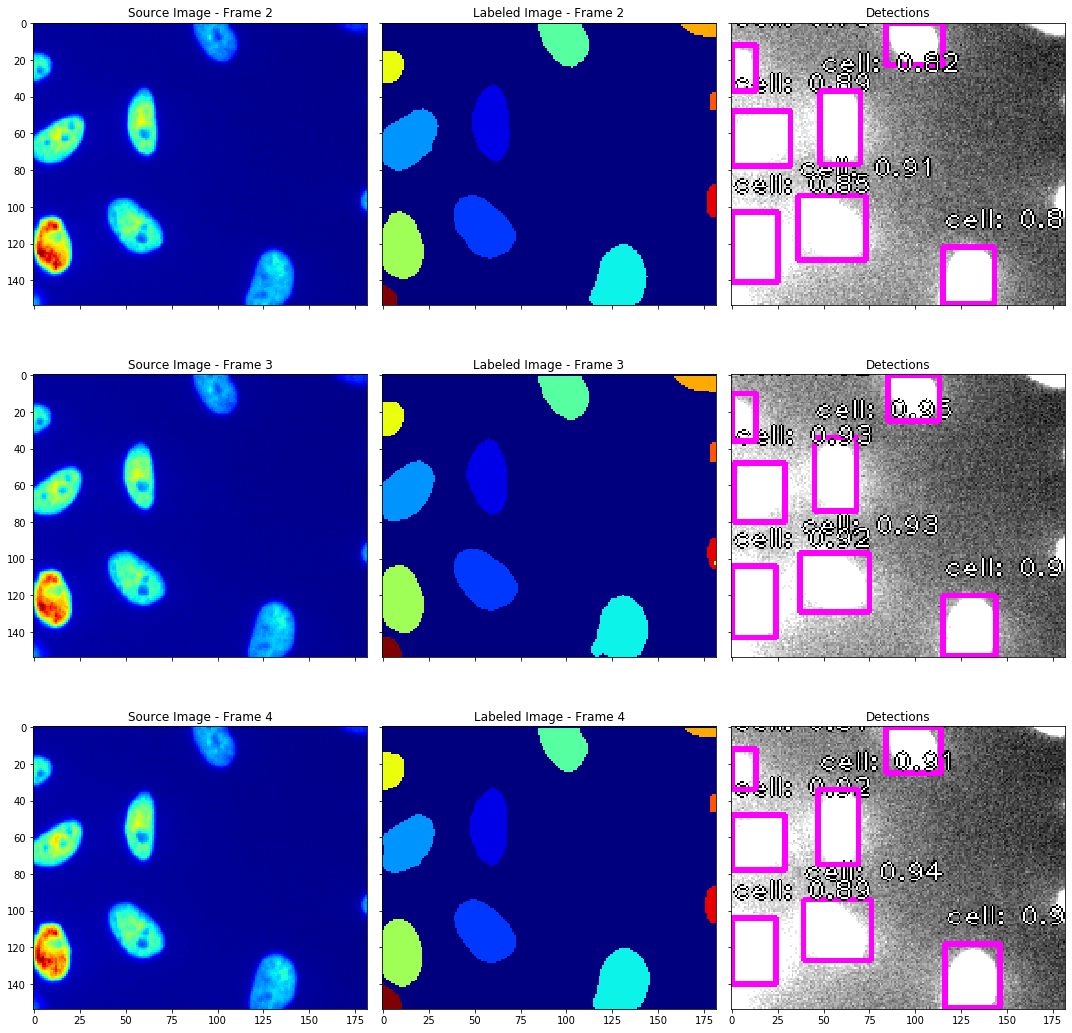

In [30]:
import matplotlib.pyplot as plt
from deepcell.utils.plot_utils import draw_masks, draw_detections

display = 0.01 * np.tile(np.expand_dims(image[0, ..., 0], axis=-1), (1, 1, 3))
gt_mask = np.squeeze(gt_mask)

draw_list = []

for i in range(fpb):
    draw = 0.1 * np.tile(image[0, i].copy(), (1, 1, 3))

    selection = np.where(final_scores[0, i] > 0.75)[0]

    # draw the masks
    draw_masks(draw, boxes[0, i], scores[0, i], masks[0, i],
               score_threshold=0.5, binarize_threshold=0.5)

    # draw detections
    draw_detections(draw, boxes[0, i], scores[0, i], labels[0, i],
                    label_to_name=lambda x: 'cell', score_threshold=0.5)

    draw_list.append(draw)

fig, axes = plt.subplots(ncols=3, nrows=fpb, figsize=(15, 15), sharex=True, sharey=True)
for i in range(fpb):
    axes[i, 0].imshow(display[i, ..., 0], cmap='jet')
    axes[i, 0].set_title('Source Image - Frame {}'.format(frame + i))

    axes[i, 1].imshow(gt_mask[i], cmap='jet')
    axes[i, 1].set_title('Labeled Image - Frame {}'.format(frame + i))

    axes[i, 2].imshow(draw_list[i], cmap='jet')
    axes[i, 2].set_title('Detections')

fig.tight_layout()
plt.show()


In [42]:
np.max(assoc_features, axis=-1)

array([[[0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781268, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781288, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0.00781254, 0.00781254, 0.00781254,
         0.00781254, 0.00781254, 0

# Appendix

### Generator Outputs